<a href="https://colab.research.google.com/github/yashikart/ML-Violation-Detection-Rapid-Token-Dump-Analysis/blob/main/Wallet_Violation_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rule-Based Detection (Basic)**

In [4]:
import pandas as pd
from datetime import timedelta
import json

# Load your CSV data
df = pd.read_csv("reports.csv")

# Parse "Created At" into datetime; handle N/A
df["Created At"] = pd.to_datetime(df["Created At"], errors="coerce")

# Filter only rows with usable timestamps
df_valid = df.dropna(subset=["Created At"])

# Group by wallet
output = []
for wallet, group in df_valid.groupby("Wallet"):
    group = group.sort_values("Created At")
    high_severity = group[group["Severity"] >= 4]

    # Check for at least 3 high-severity reports within 1 hour
    for i in range(len(high_severity) - 2):
        t1 = high_severity.iloc[i]["Created At"]
        t3 = high_severity.iloc[i + 2]["Created At"]
        if (t3 - t1) <= timedelta(hours=1):
            count = len(high_severity)
            score = min(1.0, 0.75 + 0.05 * (count - 3))
            output.append({
                "address": wallet,
                "violation": "Rapid token dump",
                "score": round(score, 2),
                "recommended_action": "freeze"
            })
            break  # Trigger only once per wallet

# Output JSON
print(json.dumps(output, indent=4))

# Optional: Save to file
with open("ml_violations.json", "w") as f:
    json.dump(output, f, indent=4)


[
    {
        "address": "0xabc123",
        "violation": "Rapid token dump",
        "score": 1.0,
        "recommended_action": "freeze"
    },
    {
        "address": "0xdef456",
        "violation": "Rapid token dump",
        "score": 0.9,
        "recommended_action": "freeze"
    }
]


In [5]:
import pandas as pd
from datetime import timedelta
import json

# Load your CSV data
df = pd.read_csv("reports.csv")

# Handle missing dates
df["Created At"] = pd.to_datetime(df["Created At"], errors="coerce")

# Group by wallet
wallets = df.groupby("Wallet")

# Results
full_report = []
missing_timestamp_wallets = []

for wallet, group in wallets:
    if group["Created At"].isnull().all():
        # No usable timestamps
        missing_timestamp_wallets.append(wallet)
        full_report.append({
            "address": wallet,
            "flagged": False,
            "reason": "All Created At timestamps are missing or invalid",
            "violation": None,
            "score": None,
            "recommended_action": None
        })
        continue

    group_valid = group.dropna(subset=["Created At"])
    group_valid = group_valid.sort_values("Created At")
    high_severity = group_valid[group_valid["Severity"] >= 4]

    if len(high_severity) < 3:
        full_report.append({
            "address": wallet,
            "flagged": False,
            "reason": f"Only {len(high_severity)} high severity reports (need 3+)",
            "violation": None,
            "score": None,
            "recommended_action": None
        })
        continue

    # Check for 3+ events within 1 hour window
    flagged = False
    for i in range(len(high_severity) - 2):
        t1 = high_severity.iloc[i]["Created At"]
        t3 = high_severity.iloc[i + 2]["Created At"]
        if (t3 - t1) <= timedelta(hours=1):
            score = min(1.0, 0.75 + 0.05 * (len(high_severity) - 3))
            full_report.append({
                "address": wallet,
                "flagged": True,
                "reason": "Rapid token dump detected",
                "violation": "Rapid token dump",
                "score": round(score, 2),
                "recommended_action": "freeze"
            })
            flagged = True
            break

    if not flagged:
        full_report.append({
            "address": wallet,
            "flagged": False,
            "reason": "No 3 high severity events within 1 hour",
            "violation": None,
            "score": None,
            "recommended_action": None
        })

# Save full report
with open("full_wallet_report.json", "w") as f:
    json.dump(full_report, f, indent=4)

# Show result summary
print(json.dumps(full_report, indent=4))


[
    {
        "address": "0x123",
        "flagged": false,
        "reason": "Only 1 high severity reports (need 3+)",
        "violation": null,
        "score": null,
        "recommended_action": null
    },
    {
        "address": "0x1234",
        "flagged": false,
        "reason": "All Created At timestamps are missing or invalid",
        "violation": null,
        "score": null,
        "recommended_action": null
    },
    {
        "address": "0x789xyz",
        "flagged": false,
        "reason": "Only 0 high severity reports (need 3+)",
        "violation": null,
        "score": null,
        "recommended_action": null
    },
    {
        "address": "0xAb5801a7D398351b8bE11C439e05C5b3259aeC9B",
        "flagged": false,
        "reason": "Only 0 high severity reports (need 3+)",
        "violation": null,
        "score": null,
        "recommended_action": null
    },
    {
        "address": "0xabc001",
        "flagged": false,
        "reason": "All Created At ti

Machine Leraning - Random Forest

In [6]:
import pandas as pd
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Load data
df = pd.read_csv("reports.csv")
df["Created At"] = pd.to_datetime(df["Created At"], errors="coerce")
df = df.dropna(subset=["Created At"])

# Feature extraction per wallet
wallet_features = []

for wallet, group in df.groupby("Wallet"):
    group = group.sort_values("Created At")
    total_reports = len(group)
    high_sev_reports = group[group["Severity"] >= 4]
    num_high_sev = len(high_sev_reports)

    # Calculate time span in hours between first and last high severity reports
    if num_high_sev > 1:
        time_span_hours = (high_sev_reports["Created At"].max() - high_sev_reports["Created At"].min()).total_seconds() / 3600
    else:
        time_span_hours = 0

    # Label: 1 if 3+ high severity reports in <=1 hour (rule-based)
    violation = 0
    for i in range(num_high_sev - 2):
        t1 = high_sev_reports.iloc[i]["Created At"]
        t3 = high_sev_reports.iloc[i + 2]["Created At"]
        if (t3 - t1) <= timedelta(hours=1):
            violation = 1
            break

    wallet_features.append({
        "wallet": wallet,
        "total_reports": total_reports,
        "num_high_sev": num_high_sev,
        "time_span_hours": time_span_hours,
        "violation": violation
    })

# Convert to DataFrame
features_df = pd.DataFrame(wallet_features)

# Prepare training data
X = features_df[["total_reports", "num_high_sev", "time_span_hours"]]
y = features_df["violation"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of violation class

# Evaluation
print(classification_report(y_test, y_pred))

# Output predictions with wallet and score
output = []
for wallet, prob in zip(features_df.loc[X_test.index, "wallet"], y_prob):
    output.append({
        "address": wallet,
        "violation_probability": round(prob, 2),
        "recommended_action": "freeze" if prob > 0.7 else "monitor"
    })

print(output)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

[{'address': '0x123', 'violation_probability': np.float64(0.08), 'recommended_action': 'monitor'}, {'address': '0x789xyz', 'violation_probability': np.float64(0.29), 'recommended_action': 'monitor'}]


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



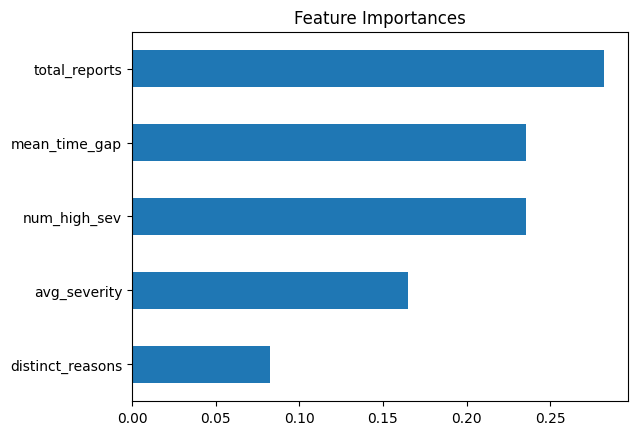

Prediction Output:
 [{'address': '0x123', 'violation_probability': np.float64(0.22), 'recommended_action': 'monitor'}, {'address': '0x789xyz', 'violation_probability': np.float64(0.32), 'recommended_action': 'monitor'}]


In [7]:
import pandas as pd
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Load data
df = pd.read_csv("reports.csv")
df["Created At"] = pd.to_datetime(df["Created At"], errors="coerce")
df = df.dropna(subset=["Created At"])

wallet_features = []

for wallet, group in df.groupby("Wallet"):
    group = group.sort_values("Created At")
    total_reports = len(group)
    high_sev_reports = group[group["Severity"] >= 4]
    num_high_sev = len(high_sev_reports)
    avg_severity = group["Severity"].mean()
    distinct_reasons = group["Reason"].nunique()

    # Time gaps between consecutive high severity reports (in minutes)
    time_gaps = []
    if num_high_sev > 1:
        times = high_sev_reports["Created At"].values
        for i in range(1, len(times)):
            gap = (times[i] - times[i-1]) / np.timedelta64(1, 'm')  # minutes
            time_gaps.append(gap)
        mean_time_gap = np.mean(time_gaps)
    else:
        mean_time_gap = None  # or a large number

    # Label based on existing rule: 3+ high severity within 1 hour
    violation = 0
    for i in range(num_high_sev - 2):
        t1 = high_sev_reports.iloc[i]["Created At"]
        t3 = high_sev_reports.iloc[i + 2]["Created At"]
        if (t3 - t1) <= timedelta(hours=1):
            violation = 1
            break

    wallet_features.append({
        "wallet": wallet,
        "total_reports": total_reports,
        "num_high_sev": num_high_sev,
        "avg_severity": avg_severity,
        "distinct_reasons": distinct_reasons,
        "mean_time_gap": mean_time_gap if mean_time_gap is not None else 9999,  # fill NaN
        "violation": violation
    })

features_df = pd.DataFrame(wallet_features)

# Prepare data
X = features_df[["total_reports", "num_high_sev", "avg_severity", "distinct_reasons", "mean_time_gap"]]
y = features_df["violation"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

# Output predictions
output = []
for wallet, prob in zip(features_df.loc[X_test.index, "wallet"], y_prob):
    output.append({
        "address": wallet,
        "violation_probability": round(prob, 2),
        "recommended_action": "freeze" if prob > 0.7 else "monitor"
    })

print("Prediction Output:\n", output)
